In [1]:
import glob
import os
import math
import sys
import time
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from scipy.optimize import least_squares
from matplotlib.widgets import Slider, Button, RadioButtons


class Visualize:

    # allows for a variety of methods to visualize the calculated 3Dmpdf. Requires both the 3Dmpdf
    # array and the 3 arrays x, y, z from which the grid was created.
        
        
    def __init__(self, m, x, y, z):

        # Args:
        
            # m: 3Dmpdf, as a 3D numpy array
            # x, y, z: each are numpy arrays whose values are used to create the meshgrid for 3Dmpdf
        
        if not all(isinstance(i, np.ndarray) for i in [m, x, y, z]):
            raise ValueError('Please enter numpy arrays for each argument')
            
        self.m = m
        self.x = x
        self.y = y
        self.z = z
        self.a = None # these two instance attributes will construct an arbitrary grid,
        self.b = None # defined here to allow for cross function usage
        
    def three_points(self, p1, p2, p3):
        # find normal from three points given
        # find two vectors from the three points which lie on the desired plane
        vec1 = p2 - p1
        vec2 = p3 - p1
        # now cross these two vectors to find a vector normal to the plane
        normal = np.cross(vec1, vec2)
    
        # now calculate the centroid of the three points given
        x_pos = (p1[0] + p2[0] + p3[0]) / 3
        y_pos = (p1[1] + p2[1] + p3[1]) / 3
        z_pos = (p1[2] + p2[2] + p3[2]) / 3
        cen_pt = np.array([x_pos, y_pos, z_pos])
        print('Center Point:', cen_pt)
        
        return normal, cen_pt
    
    
    def make_slice(self, len_a=None, len_b=None, dr=None, use_norm=None, cen_pt=None, normal=None, 
                   p1=None, p2=None, p3=None):
        
        # Args:
        
            # side_len: the side length of the square slice to be taken through the data
            # dr: determines the spacing of the grid (if dr=0.5, then there are 2 measurements every angstrom)
            # use_norm: When True, will create slice from user given normal vector and center point. When
                # false, will create slice from three points given by the user
            # cen_pt: The center of the desired slice. Used when use_norm is True
            # normal: The normal vector to desired plane. Used when use_norm is True
            # p1, p2, p3: Three points in 3D space given as numpy arrays. The desired plane goes through these points.
                # Used when use_norm is False
            
        # Returns:
        
            # Returns 2D array, representing slice through 3Dmpdf
        
        if dr is None:
            dr = 1
        if use_norm is None:
            use_norm = True
        if len_a is None:
            len_a = 10
        if len_b is None:
            len_b = 10
        if cen_pt is None:
            cen_pt = np.array([0, 0, 0])
        if normal is None:
            normal = np.array([1, 0, 0])
        if p1 is None:
            p1 = np.array([0, 1, 0])
        if p2 is None:
            p2 = np.array([1, 0, 0])
        if p3 is None:
            p3 = np.array([0, 0, 1])
        
        # First check if use_norm is False. If so, access three_points function 
        # to calculate the normal and cen_pt of the desired plane
        if use_norm is False:
            normal, cen_pt = self.three_points(p1, p2, p3)
         
        # ensure that our basis vector v1 is not the same as normal
        v1 = np.array([1, 0, 0])
        if np.allclose(v1, normal):
            v1 = np.array([0, 1, 0])
    
        # now make a matrix which will reflect any vector onto the orthogonal
        # complement of the normal vec, which is our desired plane
        # This is done by subtracting from the vector its component along the normal vector
        m_norm = np.eye(3) - (np.outer(normal, normal.T) / normal.T.dot(normal))
        
        # now reflect v1 using m_norm
        v1 = m_norm.dot(v1)
        # and create a new vector v2 that is orthogonal to both v1 and normal
        v2 = np.cross(normal, v1)
        # we now have 2 vectors to form our plane
    
        # now create and normalize Q, which will rotate an arbitrary 
        # slice to the orientation we desire
        Q = np.column_stack((v1, v2, np.zeros_like(v1)))
        Q[:,:2] /= np.linalg.norm(Q[:,:2], axis = 0)
    
        # now create an arbitrary slice
        self.a = np.arange(-len_a / 2, len_a / 2, dr)
        self.b = np.arange(-len_b / 2, len_b / 2, dr)
        self.a = np.append(self.a, len_a / 2)
        self.b = np.append(self.b, len_b / 2)
        A,B = np.meshgrid(self.a, self.b)
        locations = np.array([A.reshape(-1), B.reshape(-1), np.zeros(A.size)])  # the slice starts on the x-y plane
        # now move locations onto our two vectors, and add cen_pt to move slice into position
        locations = Q.dot(locations).T + (cen_pt)
    
        # now we need to interpolate our 3Dmpdf function over this slice
        points = (self.x, self.y, self.z)
        interp = interpn(points, self.m, locations)  # list of values of 3Dmpdf at locations
        slice1 = interp.reshape(len(self.b),len(self.a))
        
        return slice1
    
    
    def convert_1D(self):
        
        # takes XX,YY,ZZ, defined from meshgrid(x,y,z), and converts the meshgrid to 1D
        # representing distances from origin r.
        
        # Returns:
        
            # Flattened 3Dmpdf array along with the corresponding distance from origin array rarray1
            
        XX, YY, ZZ = np.meshgrid(self.x, self.y, self.z)
        rarray=np.sqrt(XX**2 + YY**2 + ZZ**2)  # make array of distances from origin r for each x,y,z point
        rarray1=np.ravel(rarray)  # put into form to plot
        m1=np.ravel(self.m)
        
        return rarray1, m1
    
    
    def smart_scale(self, sliced_plane):
        
        # for use in plotting functions
        
        data = np.ravel(sliced_plane)
        n = len(data)
        mean = sum(data) / n
        std_dev = np.sqrt(sum((x - mean) ** 2 for x in data) / n)
        cmin = mean - 2 * std_dev
        cmax = mean + 2 * std_dev
        
        return(cmin, cmax)
    
    
    def plot_slice(self, sliced_plane, contour=None, smart=None, cmin=None, cmax=None, levels=None):
    
        # Args:
        
            # sliced_plane: slice returned by "make_slice" function
            # cmin, cmax: Sets the values to which the maximum and minimum color values will be assigned. If no value is
                # given for both cmin and cmax, default scaling will be used by matplotlib
            # contour: If True, will plot the calculated slice as a contour plot. 
                # If False, as a continuous surface
            # smart: If True, will scale the colormap for the user by setting cmin and cmax to the range
                # of 2 standards deviations (intended to eliminate outliers)
            # levels: designates the number of levels the contour plot should have. Required if user designates
                # cmin and cmax while contour == True. Defaults to levels = 6 if user does not specify value
        
        # Returns:
    
            # Plots the 2D slice through 3Dmpdf as desired

        if contour is None:
            contour = False
        if smart is None:
            smart = False
        
        if smart == True:
            cmin, cmax = self.smart_scale(sliced_plane)
        
        fig, ax = plt.subplots()
        plt.subplots_adjust(left=0.25, bottom=0.38)
        
        # now we plot either a contour or continuous
        if contour == True:
            
            if cmin != None and cmax != None:
                
                if levels == None:
                    levels = 6
                    print('Number of contour levels not specified. Set as \'levels = 6\' by default')
                plot = ax.contourf(self.a, self.b, sliced_plane, levels = np.linspace(cmin, cmax, levels),
                             extend = 'both' , cmap = cm.magma)
                fig.colorbar(plot, ax=ax)
                
                return(fig, ax)
            
            else:
                
                plot = plt.contourf(self.a, self.b, sliced_plane, cmap = cm.magma)
                fig.colorbar(plot, ax=ax)
                
                return(fig, ax)
            
        else:
            plt.xlabel('x (' + r'$\AA$' + ')')
            plt.ylabel('z (' + r'$\AA$' + ')')
            plt.xlabel('[H,0,0]')
            plt.ylabel('[0,K,0]')
            plt.title('(TaSe$_{4}$)$_{2}$I at 280K, L=4.1')
            #plt.yticks([-7.5,-5,-2.5,0,2.5,5,7.5])
            a_shift = 0
            b_shift = 0

            plot = ax.imshow(sliced_plane, cmap = cm.magma, origin = 'lower', 
                       extent = [min(self.a)+a_shift, max(self.a)+a_shift, min(self.b)+b_shift, 
                                 max(self.b)+b_shift],vmin=cmin,vmax=cmax)
            fig.colorbar(plot, ax=ax)
            
            return(fig, ax)

    
    def plot_interactive(self, dr, cen_pt, normal, axis_name, len_a, len_b, len_c):
        
        # For use in the interactive function. Controls the elements that 
        # allow on-the-fly changes to the viewing slice
        
        sliced_plane = self.make_slice(len_a, len_b, dr, True, np.array([0,0,0]), np.array([0,0,1]))
        
        fig, ax = plt.subplots()
        plt.subplots_adjust(left=0.1, bottom=0.38)
        
        cmin, cmax = self.smart_scale(sliced_plane)
        
        plot = ax.imshow(sliced_plane, cmap = cm.magma, origin = 'lower', 
                extent = [min(self.a), max(self.a), min(self.b), max(self.b)], vmin = cmin, vmax = cmax)
        cbar = plt.colorbar(plot, ax=ax)
            
        axcolor = 'lightgoldenrodyellow'
        slider_axis = plt.axes([0.25, 0.2, 0.65, 0.03], facecolor=axcolor)
            
        slider = Slider(slider_axis, axis_name, -len_c, len_c, valinit=0)

        def update(val):
            adj_val = slider.val
            slice1 = self.make_slice(len_a, len_b, dr, True, cen_pt * adj_val, normal)
            cmin, cmax = self.smart_scale(slice1)
            ax.imshow(slice1, cmap = cm.magma, origin = 'lower', 
                    extent = [min(self.a), max(self.a), min(self.b), max(self.b)], vmin = cmin, vmax = cmax)
            plot.set_clim([cmin,cmax])
            fig.canvas.draw_idle()
            
        slider.on_changed(update)
            
        resetax = plt.axes([0.8, 0.26, 0.1, 0.04])
        button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')

        def reset(event):
            slider.reset()
        button.on_clicked(reset)
        plt.show()

        
    def interactive(self, plane=None, dr=None, len_a=None, len_b=None, len_c=None):
        
        # Args:
        
            # plane: User selects from 'xy', 'yz', or 'xz' for which plane they desire to view
            # dr: determines the spacing of the grid (if dr=0.5, then there are 2 measurements every angstrom)
            
        # Returns:
            
            # Outputs an interactive slice viewer for the specified plane
        
        if plane is None:
            plane = 'xy'
        if dr is None:
            dr = 1
        if len_a is None:
            len_a = (max(self.x)-min(self.x)) / 2
        if len_b is None:
            len_b = (max(self.y)-min(self.y)) / 2
        if len_c is None:
             len_c = (max(self.z)-min(self.z)) / 2
        
        if plane == 'xy':
            axis_name = 'z'
            normal = np.array([0,0,1])
            cen_pt = np.array([0,0,1])
            self.plot_interactive(dr, cen_pt, normal, axis_name, len_a, len_b, len_c)
        
        if plane == 'xz':
            axis_name = 'y'
            normal = np.array([0,1,0])
            cen_pt = np.array([0,1,0])
            self.plot_interactive(dr, cen_pt, normal, axis_name, len_a, len_b, len_c)
            
        if plane == 'yz':
            axis_name = 'x'
            normal = np.array([1,0,0])
            cen_pt = np.array([1,0,0])
            self.plot_interactive(dr, cen_pt, normal, axis_name, len_a, len_b, len_c)

In [2]:
from nexusformat.nexus import *
import os
os.chdir('E:/Shoemaker_Data/Ta2Se8I_Single_Crystal_XRD/6IDD_20210723/High-res/100K')
#help(nx)

In [3]:
a = nxload('masked_transform.nxs')

In [4]:
print(a.tree)

root:NXroot
  entry:NXgroup
    data:NXgroup
      v = float32(1201x1001x1001)


In [5]:
data1=a.entry.data.v.nxvalue

C:\Users\Jacob\anaconda3\lib\site-packages\nexusformat\nexus\tree.py:3738: RuntimeWarning: overflow encountered in long_scalars
  if (np.prod(self.shape) * np.dtype(self.dtype).itemsize


In [6]:
data1 = data1.transpose((1,2,0))
z=np.linspace(-12,12,1201)
x=np.linspace(-10,10,1001)
y=np.linspace(-10,10,1001)
np.shape(data1)

(1001, 1001, 1201)

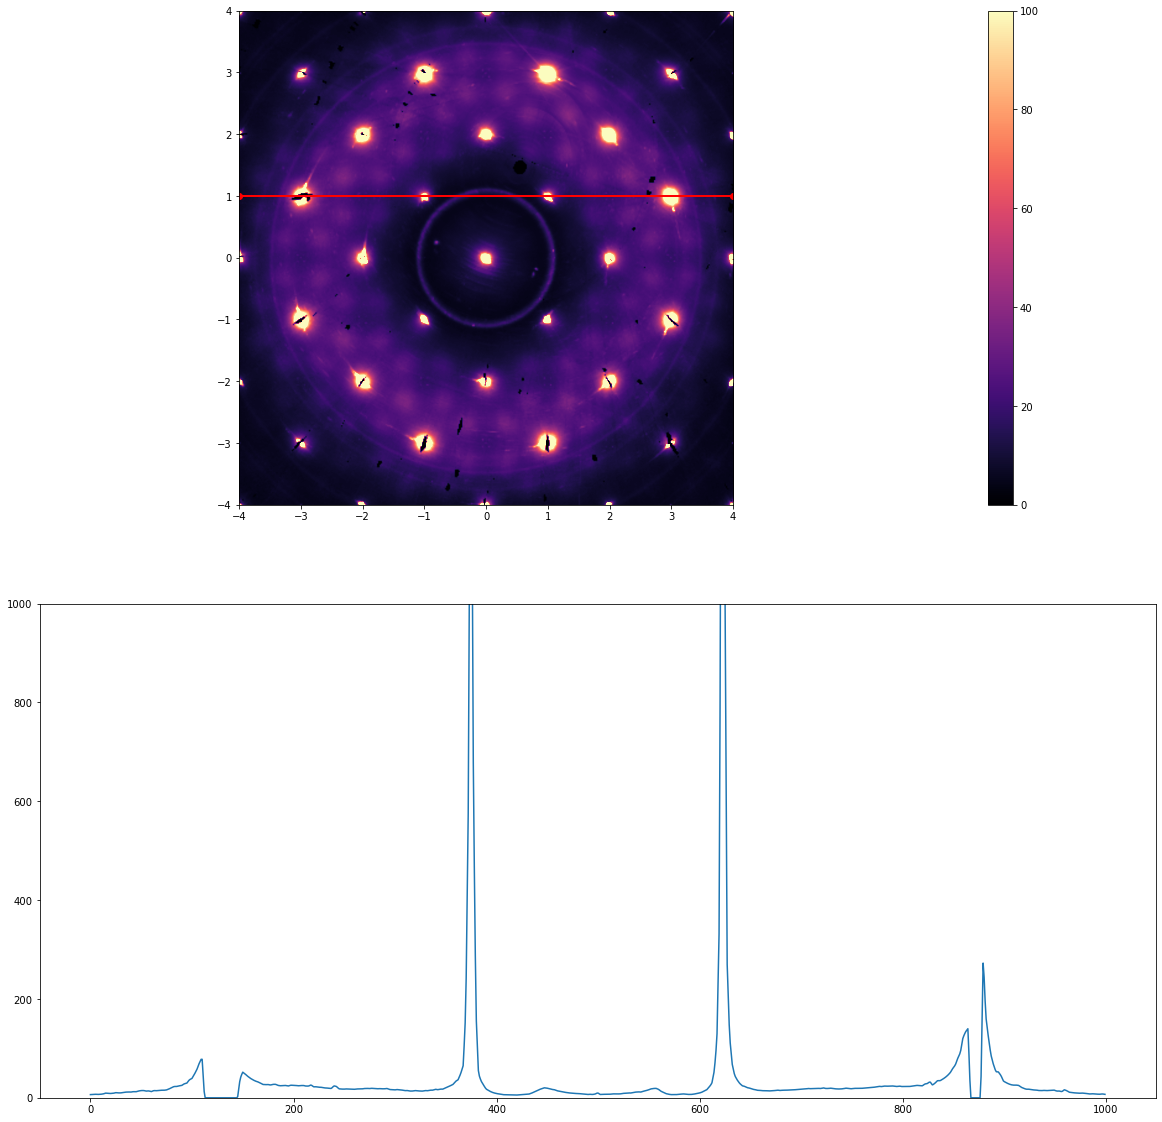

In [9]:
# find the linecut through data, integrate
# put this into visualize package

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import scipy.misc

# create your slice using make_slice function
obj=Visualize(data1,x,y,z)
a = 8
b = 8
cmin=0
cmax=100
slice2=obj.make_slice(a,b,0.005, True, np.array([0,0,4]),np.array([0,0,1]))


num_points = 1000

# using full 3d array instead...
x0, x1 = -4, 4
y0, y1 = 1, 1
z0, z1 = 4, 4
xvalues = np.linspace(x0, x1, num_points)
yvalues = np.linspace(y0, y1, num_points)
zvalues =  np.linspace(z0, z1, num_points)
fvalues = scipy.interpolate.interpn((x, y, z), data1,(xvalues,yvalues,zvalues),
                                    method='linear',bounds_error=False)

#-- Plot...
fig, ax = plt.subplots(nrows=2,figsize=(20,20))

plot = ax[0].imshow(slice2, cmap = cm.magma, origin = 'lower', 
                       extent = [-a/2, a/2, -b/2, 
                                 b/2],vmin=cmin,vmax=cmax)
fig.colorbar(plot, ax=ax[0])

#ax[0].imshow(slice2)
ax[0].plot([x0, x1], [y0, y1], 'ro-',linewidth=2.0)
ax[0].axis('image')

ax[1].set_ylim(0,1000)
ax[1].plot(fvalues)

plt.show()